### Imports

In [ ]:
!sudo add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!sudo apt-get update -qq 2>&1 > /dev/null
!sudo apt -y install -qq google-drive-ocamlfuse 2>&1 > /dev/null
!google-drive-ocamlfuse

In [ ]:
!sudo apt-get install -qq w3m # to act as web browser 
!xdg-settings set default-web-browser w3m.desktop # to set default browser
%cd /content
!mkdir drive
%cd drive
!mkdir MyDrive
%cd ..
%cd ..
!google-drive-ocamlfuse /content/drive/MyDrive

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/ENSEMBLE_PROJECT

/content/drive/MyDrive/ENSEMBLE_PROJECT


In [ ]:
!pip install torchattacks

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.9/155.9 KB 8.7 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from tqdm import tqdm

from scipy import stats as st
from sklearn.metrics import accuracy_score, f1_score

import torchattacks

In [ ]:
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
device

device(type='cpu')

### Dataloaders

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))]) 

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
from torch.cuda.random import seed
new_testset = torch.utils.data.random_split(testset, [1000,9000], generator=torch.Generator().manual_seed(11))[0]

In [ ]:
testloader = torch.utils.data.DataLoader(new_testset, batch_size=1,
                                         shuffle=False, num_workers=2)

### Utils

In [ ]:
def testAccuracy(model, test_dataloader):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            images, labels = data
            
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images = torch.autograd.Variable(images.to(device))
            labels = torch.autograd.Variable(labels.to(device))
            
            # run the model on the test set to predict labels
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    
    return(accuracy, running_loss/(len(test_dataloader)))

In [ ]:
def train(model, num_epochs):

    # Define your execution device
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("The model will be running on", device, "device")
    # Convert model parameters and buffers to CPU or Cuda
    model.to(device)

    train_losses = []
    #train_accs = []
    test_losses = []
    test_accs = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        #running_acc = 0.0

        for images, labels in tqdm(trainloader):
            #print(labels)
            # get the inputs
            images = torch.autograd.Variable(images.to(device))
            labels = torch.autograd.Variable(labels.to(device))

            # zero the parameter gradients
            optimizer.zero_grad()
            # predict classes using images from the training set
            outputs = model(images)
            # compute the loss based on model output and real labels
            loss = criterion(outputs, labels)
            # backpropagate the loss
            loss.backward()
            # adjust parameters based on the calculated gradients
            optimizer.step()

            # Let's print statistics for every 1,000 images
            running_loss += loss.item()     # extract the loss value
        
        #train_accuracy,train_loss = testAccuracy(trainloader)
        #train_accs.append(train_accuracy)
        train_losses.append(running_loss/len(trainloader))

        # Compute and print the average accuracy fo this epoch when tested over all 10000 test images
        accuracy,test_loss = testAccuracy(model, testloader)

        test_accs.append(accuracy)
        test_losses.append(test_loss)
        
        print(f'Epoch {epoch+1}--> Train Loss: {running_loss/len(trainloader)}\t Test Loss: {test_loss}\t Test Acc: {accuracy}')
    
    return model, train_losses, test_losses, test_accs

In [ ]:
def ind_acc(test_dataloader, model):
    
    model.eval()
    accuracy = 0.0
    total = 0.0
    running_loss = 0.0
    predictions = []
    gt = []
    
    with torch.no_grad():
        for data in tqdm(test_dataloader):
            images, labels = data
            
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
            images = torch.autograd.Variable(images.to(device))
            labels = torch.autograd.Variable(labels.to(device))
            
            # run the model on the test set to predict labels
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            # the label with the highest energy will be our prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            
            predictions.append(np.array(predicted.cpu()))
            gt.append(np.array(labels.cpu()))
            #print(len(predictions))
            accuracy += (predicted == labels).sum().item()

    # compute the accuracy over all test images
    accuracy = (100 * accuracy / total)
    #print('Accuracy of individual: ', accuracy)
    return predictions, gt, accuracy

In [ ]:
def ensemble_acc(n_models):
    preds = []
    accs = []
    for i in range(n_models):
        model = Net()
        model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
        _ = model.to(device)

        pred, gt, acc = ind_acc(testloader, model)
        accs.append(acc)
        print(f'Accuracy of model_{i} : ', acc)
        preds.append(np.concatenate(pred))
        
    preds_arr = np.array(preds)
    mode = st.mode(preds_arr)
    ensemble_decisions = mode.mode.reshape(len(preds[0]),1)
    
    gt = np.concatenate(gt).reshape(1000,1)
    print('Avg Acc of Individuals : ', np.mean(accs))
    print('Ensemble Accuracy : ', accuracy_score(gt, ensemble_decisions)*100)

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    #print(perturbed_image.min(), perturbed_image.max())
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
def imshow(img, title):
    npimg = img.numpy()
    fig = plt.figure(figsize = (5, 15))
    plt.imshow(np.transpose(npimg,(1,2,0)))
    plt.title(title)
    plt.show()

In [ ]:
def apply_fgsm(eps, model_base):
  model_base.eval()

  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      ####

      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min

      ####
      images.requires_grad = True      

      labels = labels.to(device)
      outputs = model_base(images)

      loss = criterion(outputs, labels)
      model_base.zero_grad()
      loss.backward()

      data_grad = images.grad.data

      images_attack = fgsm_attack(images, eps, data_grad).to(device)
      outputs_attack = model_base(images_attack)
      
      _, pre = torch.max(outputs.data, 1)
      _, pre_attack = torch.max(outputs_attack.data, 1)

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()
      
      if correct == 1:
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [testset.classes[i] for i in pre])
        imshow(torchvision.utils.make_grid(images_attack.cpu().data, normalize=True), [testset.classes[i] for i in pre_attack])

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_fgsm_ensemble(eps, n_models):
  
  models = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      _ = model.to(device)
      models.append(model)
    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels.to(device)
      
      pre_preds = []
      pre_attack_preds = []

      for model in models:
          outputs = model(images)
          loss = criterion(outputs, labels)
          model.zero_grad()
          loss.backward()
          data_grad = images.grad.data

          images_attack = fgsm_attack(images, eps, data_grad).to(device)
          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      #print(pre_preds_arr)
      #print(mode.mode[0])
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      #print(pre_attack_preds_arr)
      #print(mode.mode[0])
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      
  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def attack_BIM(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Basic Iterative Method (BIM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''
    model.to(device)
    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index]).to(device)

    # Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 32, 32]))
    assert(class_index.shape == torch.Size([1]))
    
    # Initialize adversarial image as image according to equation 2.1
    image_adver = image.clone()    
    image_adver = image_adver.to(device)
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)

    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach().to(device)
        image_adver.requires_grad=True
        
        # Compute cost with example image_adversarial        
        pred = model(image_adver)        
        loss = criterion(pred, class_index)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       
        
        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 2.2
        image_prime = image_adver + alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 2.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 2.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    return image_adver.to(device)

In [ ]:
def apply_bim(model_base, epsilon, alpha, num_iterations):
  model_base.eval()

  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      ####

      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min

      ####
      images.requires_grad = True      
      
      labels = labels.to(device)
      outputs = model_base(images)

      images_attack = attack_BIM((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261), model_base, images, labels, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations).to(device)

      outputs_attack = model_base(images_attack)
      
      _, pre = torch.max(outputs.data, 1)
      _, pre_attack = torch.max(outputs_attack.data, 1)

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      if correct == 1:
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [testset.classes[i] for i in pre])
        imshow(torchvision.utils.make_grid(images_attack.cpu().data, normalize=True), [testset.classes[i] for i in pre_attack])

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_BIM_ensemble(epsilon, alpha, num_iterations, n_models):
  
  models = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      _ = model.to(device)
      models.append(model)
    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels.to(device)
      
      pre_preds = []
      pre_attack_preds = []

      for model in models:
          outputs = model(images)
          

          images_attack = attack_BIM((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261), model_base, images, labels, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations).to(device)

          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      
  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def attack_ILLM(mean, std, model, image, class_index, epsilon, alpha, num_iterations=10):
    '''
    Applies given number of steps of the Iterative Least Likely Method (ILLM) attack on the input image.
    
    Inputs:
    mean           -- Mean from data preparation
    std            -- Standard deviation from data preparation
    model          -- Network under attack
    image          -- Image data as tensor of shape (1, 3, 224, 224)
    class_index    -- Label from image as numpy array   
    epsilon        -- Hyperparameter for sign method. Has to be scaled to epsilon/255
    alpha          -- Hyperparameter for iterative step as absolute value. Has to be scaled to alpha/255
    num_iterations -- Number of iterations to perform. Default is 10. It is recommended to use the heuristic from the
                      paper "Adversarial Examples in the Pysical World" to determine the number of iterations
    
    Returns:
    image_adver    -- Adversarial image as tensor
    '''
    model.to(device)
    # Convert label to torch tensor of shape (1)
    class_index = torch.tensor([class_index]).to(device)

    # Check input image and label shapes
    assert(image.shape == torch.Size([1, 3, 32, 32]))
    assert(class_index.shape == torch.Size([1]))
    
    # Initialize adversarial image as image according to equation 3.1
    image_adver = image.clone().to(device)   
    
    # Calculate normalized range [0, 1] and convert them to tensors
    zero_normed = [-m/s for m,s in zip(mean, std)]
    zero_normed = torch.tensor(zero_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    max_normed = [(1-m)/s for m,s in zip(mean,std)]
    max_normed = torch.tensor(max_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    # Calculate normalized alpha
    alpha_normed = [alpha/s for s in std]
    alpha_normed = torch.tensor(alpha_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)

    # Calculated normalized epsilon and convert it to a tensor
    eps_normed = [epsilon/s for s in std]
    eps_normed = torch.tensor(eps_normed, dtype=torch.float).unsqueeze(-1).unsqueeze(-1).to(device)
    
    # Calculate the maximum change in pixel value using epsilon to be later used in clip function
    image_plus = image + eps_normed
    image_minus = image - eps_normed
    
    for i in range(num_iterations):
        
        # Make a copy and detach so the computation graph can be constructed
        image_adver = image_adver.clone().detach()
        image_adver.requires_grad=True
        
        # Compute gradient of cost with least likely class     
        pred = model(image_adver)
        least_likeliest_class = torch.argmin(pred)
        least_likeliest_class.unsqueeze_(0)     
        loss = criterion(pred, least_likeliest_class)        
        model.zero_grad()        
        loss.backward()        
        grad_x = image_adver.grad.data       

        # Check if gradient exists
        assert(image_adver.grad is not None)
               
        # Compute X_prime according to equation 3.2
        image_prime = image_adver - alpha_normed * grad_x.detach().sign()
        assert(torch.equal(image_prime, image_adver) == False)
      
        # Equation 3.3 part 1
        third_part_1 = torch.max(image_minus, image_prime)
        third_part = torch.max(zero_normed, third_part_1)
              
        # Equation 3.3 part 2
        image_adver = torch.min(image_plus, third_part)                 
        image_adver = torch.min(max_normed, image_adver)                        

    return image_adver.to(device)

In [ ]:
def apply_illm(model_base, epsilon, alpha, num_iterations):
  model_base.eval()

  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      ####

      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min

      ####
      images.requires_grad = True      
      
      labels = labels.to(device)
      outputs = model_base(images)

      images_attack = attack_ILLM((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261), model_base, images, labels, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations).to(device)

      outputs_attack = model_base(images_attack)
      
      _, pre = torch.max(outputs.data, 1)
      _, pre_attack = torch.max(outputs_attack.data, 1)

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      if correct == 1:
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [testset.classes[i] for i in pre])
        imshow(torchvision.utils.make_grid(images_attack.cpu().data, normalize=True), [testset.classes[i] for i in pre_attack])

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_ILLM_ensemble(epsilon, alpha, num_iterations, n_models):
  
  models = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      _ = model.to(device)
      models.append(model)
    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels.to(device)
      
      pre_preds = []
      pre_attack_preds = []

      for model in models:
          outputs = model(images)

          images_attack = attack_ILLM((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261), model_base, images, labels, epsilon=epsilon, alpha=alpha, num_iterations=num_iterations).to(device)

          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_torchattacks(model_base, attack):
  
  model_base.eval()

  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      ####

      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min

      ####
      images.requires_grad = True      
      
      labels = labels.to(device)
      outputs = model_base(images)

      images_attack = attack(images, labels)

      outputs_attack = model_base(images_attack)
      
      _, pre = torch.max(outputs.data, 1)
      _, pre_attack = torch.max(outputs_attack.data, 1)

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      if correct == 1:
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [testset.classes[i] for i in pre])
        imshow(torchvision.utils.make_grid(images_attack.cpu().data, normalize=True), [testset.classes[i] for i in pre_attack])

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_deepfool_ensemble(steps, overshoot, n_models):
  
  models = []
  deepfools = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      _ = model.to(device)
      models.append(model)
      deepfool = torchattacks.DeepFool(model, steps=steps, overshoot=overshoot)
      deepfools.append(deepfool)

    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels.to(device)
      
      pre_preds = []
      pre_attack_preds = []

      for i, model in enumerate(models):

          outputs = model(images)
          
          images_attack = deepfools[i](images, labels)
          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()


  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_onepixel_ensemble(pixels=1, steps=10, popsize=10, inf_batch=128, n_models=10):
  
  models = []
  one_pixels = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      _ = model.to(device)
      models.append(model)
      one_pixel = torchattacks.OnePixel(model, pixels=pixels, steps=steps, popsize=popsize, inf_batch=inf_batch)
      one_pixels.append(one_pixel)

    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images.to(device)
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels.to(device)
      
      pre_preds = []
      pre_attack_preds = []

      for i, model in enumerate(models):

          outputs = model(images)
          
          images_attack = one_pixels[i](images, labels)
          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_cw(model_base, attack):
  
  model_base.eval()

  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images
      ####

      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min

      ####
      images.requires_grad = True      
      
      labels = labels
      outputs = model_base(images)

      images_attack = attack(images, labels)

      outputs_attack = model_base(images_attack)
      
      _, pre = torch.max(outputs.data, 1)
      _, pre_attack = torch.max(outputs_attack.data, 1)

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()

      if correct == 1:
        imshow(torchvision.utils.make_grid(images.cpu().data, normalize=True), [testset.classes[i] for i in pre])
        imshow(torchvision.utils.make_grid(images_attack.cpu().data, normalize=True), [testset.classes[i] for i in pre_attack])

  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

In [ ]:
def apply_cw_ensemble(c=1, kappa=0, steps=10, lr=0.01, n_models=10):
  
  models = []
  cws = []
  for i in range(n_models):
      model = Net()
      model.load_state_dict(torch.load(f'img_weights/model_{i}.pt'))
      _ = model.eval()
      models.append(model)
      cw = torchattacks.CW(model, c=c, kappa=kappa, steps=steps, lr=lr)
      cws.append(cw)

    
  correct = 0
  correct_attack = 0
  total = 0

  for images, labels in tqdm(testloader):
      
      images = images
      
      ####
      images_min, images_max = images.min(), images.max()
      new_min, new_max = 0.0, 1.0
      images = (images - images_min)/(images_max - images_min)*(new_max - new_min) + new_min
      ####
      
      images.requires_grad = True      

      labels = labels
      
      pre_preds = []
      pre_attack_preds = []

      for i, model in enumerate(models):

          outputs = model(images)
          
          images_attack = cws[i](images, labels)
          outputs_attack = model(images_attack)
      
          _, pre = torch.max(outputs.data, 1)
          _, pre_attack = torch.max(outputs_attack.data, 1)
          pre_preds.append(int(pre.cpu()))
          pre_attack_preds.append(int(pre_attack.cpu()))

      pre_preds_arr = np.array(pre_preds)
      mode = st.mode(pre_preds_arr)
      pre = mode.mode[0]

      pre_attack_preds_arr = np.array(pre_attack_preds)
      mode = st.mode(pre_attack_preds_arr)
      pre_attack = mode.mode[0]

      total += 1
      correct += (pre == labels).sum()
      correct_attack += (pre_attack == labels).sum()


  print() 
  print('Accuracy of test text: %f %%' % (100 * float(correct) / total))
  print('Accuracy of test text: %f %%' % (100 * float(correct_attack) / total))

  return (100 * float(correct) / total), (100 * float(correct_attack) / total)

### Model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        ###
        x_min, x_max = x.min(), x.max()
        new_min, new_max = 0.0, 1.0
        x = (x - x_min)/(x_max - x_min)*(new_max - new_min) + new_min
        #print(x.min(), x.max())
        ###
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_base = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_base.parameters())

In [ ]:
model_base

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

### Training

In [ ]:
#model_base, train_losses, test_losses, test_accs = train(model_base, 20)

The model will be running on cuda:0 device


100%|██████████| 40/40 [00:02<00:00, 18.94it/s]


Epoch 1--> Train Loss: 1.9727046568782962	 Test Loss: 1.7948860734701158	 Test Acc: 33.9


100%|██████████| 40/40 [00:03<00:00, 13.21it/s]


Epoch 2--> Train Loss: 1.7227625542757463	 Test Loss: 1.661147740483284	 Test Acc: 39.4


100%|██████████| 40/40 [00:02<00:00, 18.40it/s]


Epoch 3--> Train Loss: 1.6232909967704696	 Test Loss: 1.557965874671936	 Test Acc: 42.95


100%|██████████| 40/40 [00:02<00:00, 18.67it/s]


Epoch 4--> Train Loss: 1.5365587126235574	 Test Loss: 1.4805147886276244	 Test Acc: 45.93


100%|██████████| 40/40 [00:02<00:00, 18.55it/s]


Epoch 5--> Train Loss: 1.47189647141768	 Test Loss: 1.4674995064735412	 Test Acc: 46.0


100%|██████████| 40/40 [00:02<00:00, 17.69it/s]


Epoch 6--> Train Loss: 1.4137340711087596	 Test Loss: 1.3797660410404204	 Test Acc: 49.81


100%|██████████| 40/40 [00:02<00:00, 18.51it/s]


Epoch 7--> Train Loss: 1.3641126313988043	 Test Loss: 1.3394270271062851	 Test Acc: 50.8


100%|██████████| 40/40 [00:02<00:00, 19.05it/s]


Epoch 8--> Train Loss: 1.3334501501248808	 Test Loss: 1.3296662837266922	 Test Acc: 51.73


100%|██████████| 40/40 [00:02<00:00, 18.94it/s]


Epoch 9--> Train Loss: 1.3000664352154245	 Test Loss: 1.2896848261356353	 Test Acc: 53.34


100%|██████████| 40/40 [00:02<00:00, 15.90it/s]


Epoch 10--> Train Loss: 1.261041830388867	 Test Loss: 1.302107760310173	 Test Acc: 53.36


100%|██████████| 40/40 [00:02<00:00, 18.90it/s]


Epoch 11--> Train Loss: 1.243337824636576	 Test Loss: 1.2510583370923996	 Test Acc: 55.67


100%|██████████| 40/40 [00:02<00:00, 18.26it/s]


Epoch 12--> Train Loss: 1.2100814973213234	 Test Loss: 1.2287875235080719	 Test Acc: 55.96


100%|██████████| 40/40 [00:02<00:00, 18.65it/s]


Epoch 13--> Train Loss: 1.1873722350110814	 Test Loss: 1.2166138112545013	 Test Acc: 56.38


100%|██████████| 40/40 [00:02<00:00, 18.70it/s]


Epoch 14--> Train Loss: 1.1660331162262936	 Test Loss: 1.199686849117279	 Test Acc: 57.83


100%|██████████| 40/40 [00:02<00:00, 18.43it/s]


Epoch 15--> Train Loss: 1.1448380308491843	 Test Loss: 1.2059760093688965	 Test Acc: 57.36


100%|██████████| 40/40 [00:02<00:00, 18.40it/s]


Epoch 16--> Train Loss: 1.1236250853660155	 Test Loss: 1.161749005317688	 Test Acc: 58.89


100%|██████████| 40/40 [00:02<00:00, 18.74it/s]


Epoch 17--> Train Loss: 1.1068495776580305	 Test Loss: 1.1826039493083953	 Test Acc: 58.55


100%|██████████| 40/40 [00:02<00:00, 18.61it/s]


Epoch 18--> Train Loss: 1.088670747924824	 Test Loss: 1.147607332468033	 Test Acc: 59.27


100%|██████████| 40/40 [00:02<00:00, 18.23it/s]


Epoch 19--> Train Loss: 1.0722296180165545	 Test Loss: 1.1316464871168137	 Test Acc: 60.16


100%|██████████| 40/40 [00:02<00:00, 18.20it/s]

Epoch 20--> Train Loss: 1.0586014189282242	 Test Loss: 1.1591631710529327	 Test Acc: 59.25


In [ ]:
#torch.save(model_base.state_dict(), 'img_weights/model_base.pt')

### Ensemble

In [ ]:
# 10 MODELS
'''
models = []
for i in range(10):
    model = Net()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    model_base, train_losses, test_losses, test_accs = train(model, 20)
    
    torch.save(model.state_dict(), f'img_weights/model_{i}.pt')

    models.append(model)
'''

In [ ]:
ensemble_acc(10)

100%|██████████| 1000/1000 [00:09<00:00, 100.05it/s]


Accuracy of model_0 :  56.5


100%|██████████| 1000/1000 [00:02<00:00, 346.47it/s]


Accuracy of model_1 :  56.7


100%|██████████| 1000/1000 [00:02<00:00, 335.40it/s]


Accuracy of model_2 :  55.6


100%|██████████| 1000/1000 [00:02<00:00, 336.51it/s]


Accuracy of model_3 :  56.5


100%|██████████| 1000/1000 [00:02<00:00, 343.78it/s]


Accuracy of model_4 :  55.5


100%|██████████| 1000/1000 [00:02<00:00, 345.72it/s]


Accuracy of model_5 :  53.1


100%|██████████| 1000/1000 [00:02<00:00, 346.80it/s]


Accuracy of model_6 :  57.0


100%|██████████| 1000/1000 [00:02<00:00, 348.54it/s]


Accuracy of model_7 :  53.5


100%|██████████| 1000/1000 [00:02<00:00, 347.35it/s]


Accuracy of model_8 :  56.5


100%|██████████| 1000/1000 [00:02<00:00, 342.08it/s]

Accuracy of model_9 :  57.4
Avg Acc of Individuals :  55.83
Ensemble Accuracy :  60.8


### Epsilon List

In [ ]:
eps_list = [0.001, 0.005, 0.01, 0.02]

### FGSM Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()
_ = model.to(device)

  0%|          | 1/1000 [00:00<02:06,  7.92it/s]

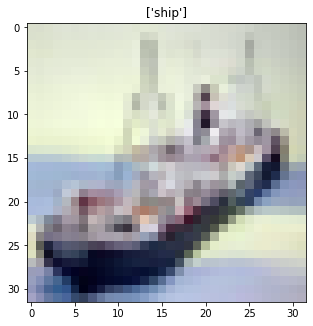

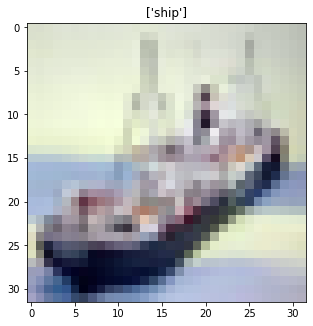

100%|██████████| 1000/1000 [00:06<00:00, 159.36it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 56.300000 %


(56.3, 56.3)

In [ ]:
apply_fgsm(0.0, model)

  0%|          | 1/1000 [00:00<01:58,  8.40it/s]

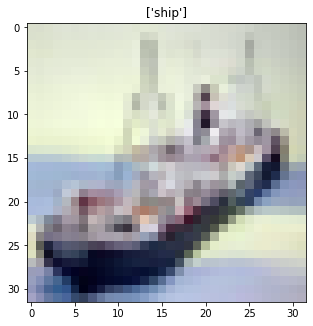

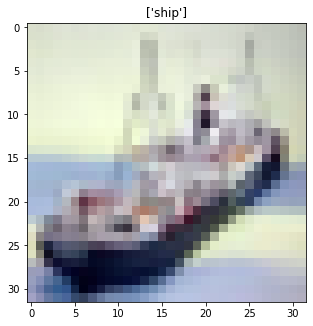

100%|██████████| 1000/1000 [00:06<00:00, 156.56it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 52.500000 %


(56.3, 52.5)

In [ ]:
apply_fgsm(0.001, model)

  0%|          | 1/1000 [00:00<01:52,  8.90it/s]

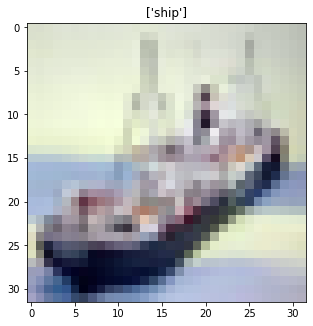

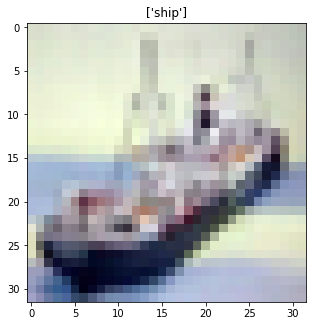

100%|██████████| 1000/1000 [00:06<00:00, 166.65it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 38.600000 %


(56.3, 38.6)

In [ ]:
apply_fgsm(0.005, model)

  0%|          | 1/1000 [00:00<01:50,  9.03it/s]

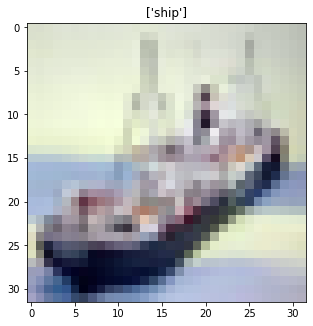

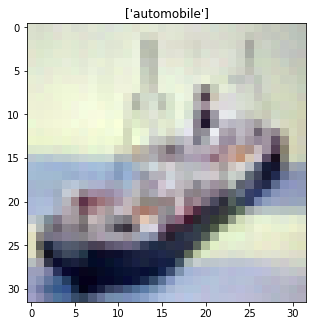

100%|██████████| 1000/1000 [00:06<00:00, 165.89it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 25.400000 %


(56.3, 25.4)

In [ ]:
apply_fgsm(0.01, model)

  0%|          | 1/1000 [00:00<02:04,  8.03it/s]

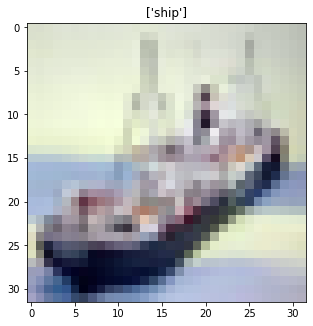

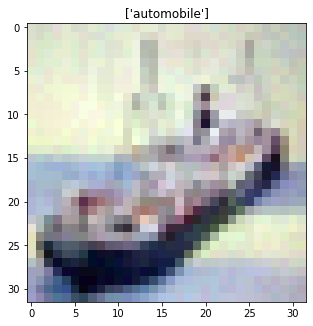

100%|██████████| 1000/1000 [00:06<00:00, 164.89it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 9.700000 %


(56.3, 9.7)

In [ ]:
apply_fgsm(0.02, model)

### FGSM Attack to Ensemble

In [ ]:
apply_fgsm_ensemble(0.001, 10)

100%|██████████| 1000/1000 [00:37<00:00, 26.71it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 58.800000 %


(60.8, 58.8)

In [ ]:
apply_fgsm_ensemble(0.005, 10)

100%|██████████| 1000/1000 [00:34<00:00, 29.32it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 49.800000 %


(60.8, 49.8)

In [ ]:
apply_fgsm_ensemble(0.01, 10)

100%|██████████| 1000/1000 [00:33<00:00, 29.91it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 39.800000 %


(60.8, 39.8)

In [ ]:
apply_fgsm_ensemble(0.02, 10)

100%|██████████| 1000/1000 [00:35<00:00, 28.10it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 27.100000 %


(60.8, 27.1)

### BIM Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()
_ = model.to(device)

  0%|          | 1/1000 [00:00<02:14,  7.42it/s]

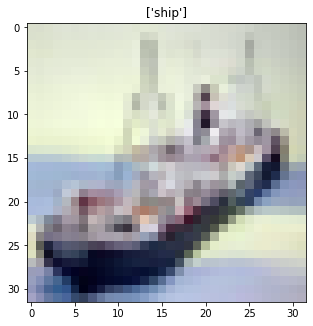

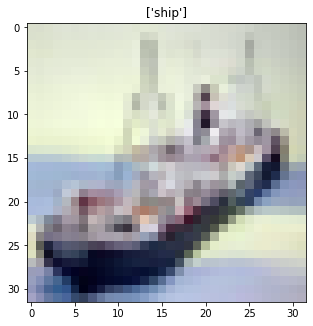

100%|██████████| 1000/1000 [00:29<00:00, 34.44it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 56.300000 %


(56.3, 56.3)

In [ ]:
apply_bim(model, 0.0, 0.001, 10)

  0%|          | 1/1000 [00:00<04:02,  4.12it/s]

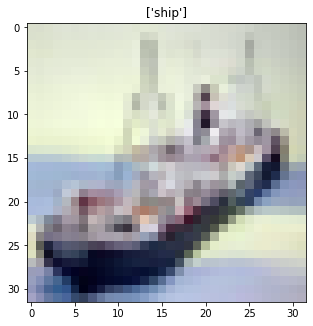

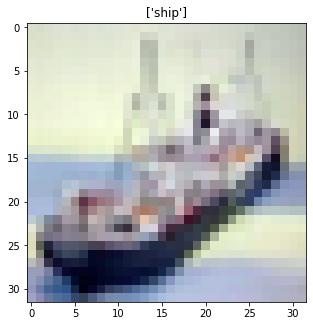

100%|██████████| 1000/1000 [00:29<00:00, 34.15it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 40.700000 %


(56.3, 40.7)

In [ ]:
apply_bim(model, 0.001, 0.001, 10)

  0%|          | 1/1000 [00:00<02:09,  7.73it/s]

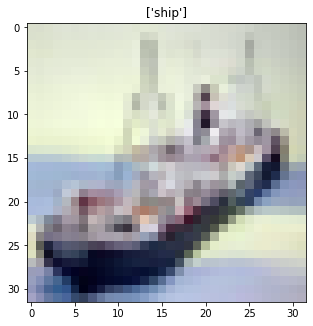

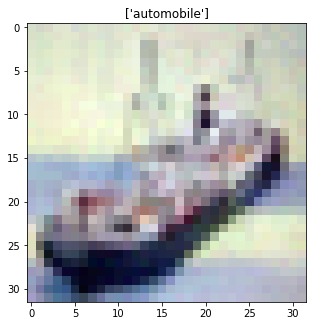

100%|██████████| 1000/1000 [00:29<00:00, 34.28it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 5.200000 %


(56.3, 5.2)

In [ ]:
apply_bim(model, 0.005, 0.001, 10)

  0%|          | 1/1000 [00:00<02:14,  7.42it/s]

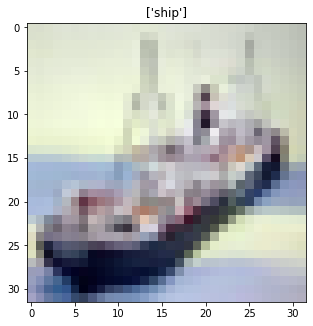

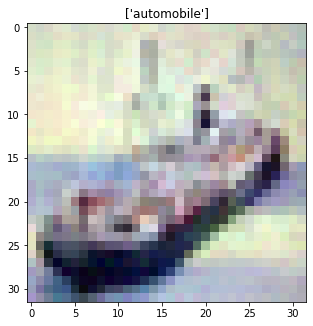

100%|██████████| 1000/1000 [00:28<00:00, 35.24it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 0.200000 %


(56.3, 0.2)

In [ ]:
apply_bim(model, 0.01, 0.001, 10)

  0%|          | 1/1000 [00:00<02:26,  6.82it/s]

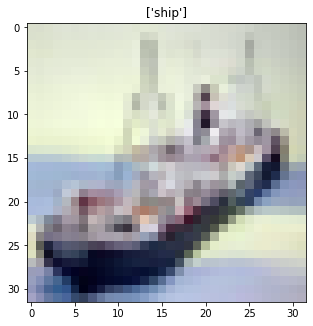

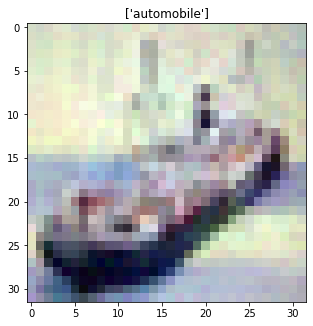

100%|██████████| 1000/1000 [00:28<00:00, 35.33it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 0.200000 %


(56.3, 0.2)

In [ ]:
apply_bim(model, 0.02, 0.001, 10)

### BIM Attack to Ensemble

In [ ]:
apply_BIM_ensemble(0.001, 0.001, 10, 10)

100%|██████████| 1000/1000 [04:32<00:00,  3.67it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.600000 %


(60.8, 60.6)

In [ ]:
apply_BIM_ensemble(0.005, 0.001, 10, 10)

100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.700000 %


(60.8, 60.7)

In [ ]:
apply_BIM_ensemble(0.01, 0.001, 10, 10)

100%|██████████| 1000/1000 [04:15<00:00,  3.92it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 61.000000 %


(60.8, 61.0)

In [ ]:
apply_BIM_ensemble(0.02, 0.001, 10, 10)

100%|██████████| 1000/1000 [04:12<00:00,  3.96it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 61.000000 %


(60.8, 61.0)

### ILLM Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()
_ = model.to(device)

  0%|          | 1/1000 [00:00<02:37,  6.33it/s]

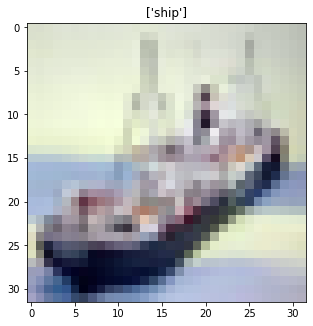

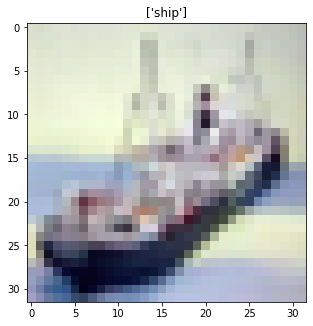

100%|██████████| 1000/1000 [00:30<00:00, 32.82it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 56.200000 %


(56.3, 56.2)

In [ ]:
apply_illm(model, epsilon=0.001, alpha=0.001, num_iterations=10)

  0%|          | 1/1000 [00:00<02:13,  7.49it/s]

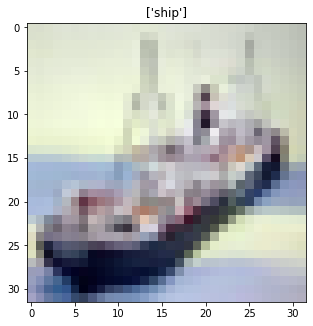

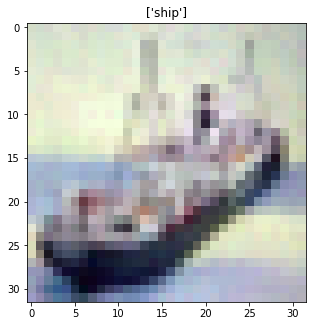

100%|██████████| 1000/1000 [00:28<00:00, 34.73it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 47.800000 %


(56.3, 47.8)

In [ ]:
apply_illm(model, epsilon=0.005, alpha=0.001, num_iterations=10)

  0%|          | 1/1000 [00:00<02:34,  6.48it/s]

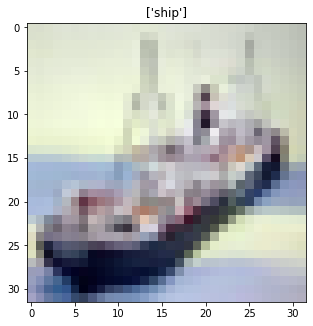

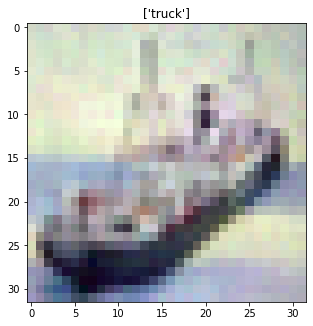

100%|██████████| 1000/1000 [00:28<00:00, 34.81it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 34.900000 %


(56.3, 34.9)

In [ ]:
apply_illm(model, epsilon=0.01, alpha=0.001, num_iterations=10)

  0%|          | 1/1000 [00:00<02:13,  7.49it/s]

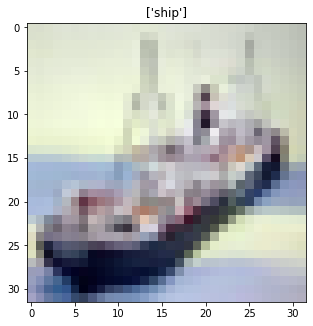

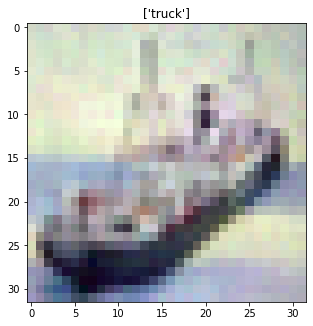

100%|██████████| 1000/1000 [00:28<00:00, 34.92it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 34.900000 %


(56.3, 34.9)

In [ ]:
apply_illm(model, epsilon=0.02, alpha=0.001, num_iterations=10)

### ILLM Attack to Ensemble

In [ ]:
apply_ILLM_ensemble(epsilon=0.001, alpha=0.001, num_iterations=10, n_models=10)

100%|██████████| 1000/1000 [04:19<00:00,  3.86it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.500000 %


(60.8, 60.5)

In [ ]:
apply_ILLM_ensemble(epsilon=0.005, alpha=0.001, num_iterations=10, n_models=10)

100%|██████████| 1000/1000 [04:00<00:00,  4.16it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 59.900000 %


(60.8, 59.9)

In [ ]:
apply_ILLM_ensemble(epsilon=0.01, alpha=0.001, num_iterations=10, n_models=10)

100%|██████████| 1000/1000 [04:01<00:00,  4.14it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.300000 %


(60.8, 60.3)

In [ ]:
apply_ILLM_ensemble(epsilon=0.02, alpha=0.001, num_iterations=10, n_models=10)

100%|██████████| 1000/1000 [04:00<00:00,  4.15it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.300000 %


(60.8, 60.3)

### DeepFool Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()
_ = model.to(device)

  0%|          | 0/1000 [00:00<?, ?it/s]

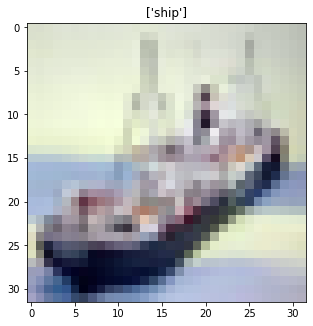

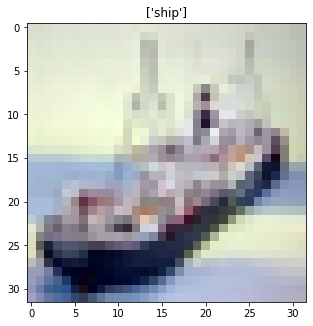

100%|██████████| 1000/1000 [01:14<00:00, 13.49it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 34.600000 %


(56.3, 34.6)

In [ ]:
deepfool = torchattacks.DeepFool(model, steps=10, overshoot=0.001)
apply_torchattacks(model, deepfool)

  0%|          | 0/1000 [00:00<?, ?it/s]

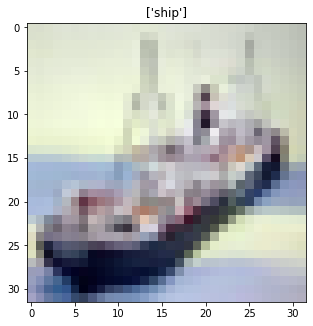

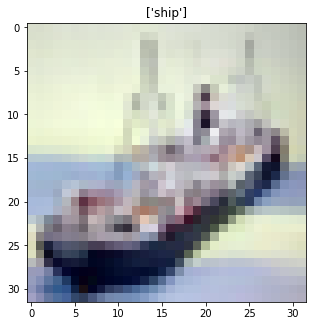

100%|██████████| 1000/1000 [01:11<00:00, 13.90it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 32.200000 %


(56.3, 32.2)

In [ ]:
deepfool = torchattacks.DeepFool(model, steps=10, overshoot=0.005)
apply_torchattacks(model, deepfool)

  0%|          | 0/1000 [00:00<?, ?it/s]

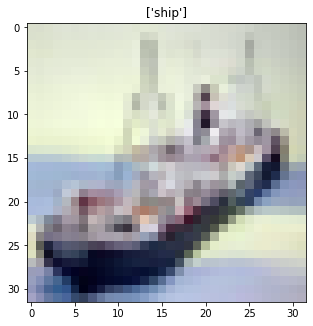

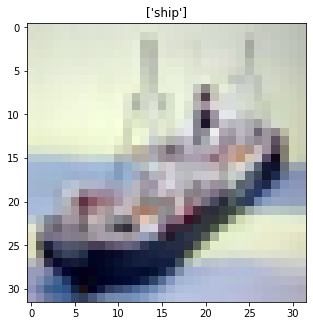

100%|██████████| 1000/1000 [01:09<00:00, 14.39it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 32.400000 %


(56.3, 32.4)

In [ ]:
deepfool = torchattacks.DeepFool(model, steps=10, overshoot=0.01)
apply_torchattacks(model, deepfool)

  0%|          | 1/1000 [00:00<05:04,  3.29it/s]

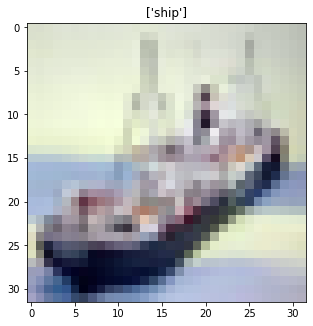

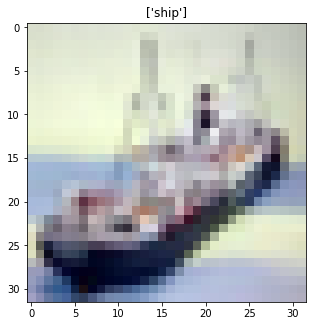

100%|██████████| 1000/1000 [01:07<00:00, 14.72it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 30.600000 %


(56.3, 30.6)

In [ ]:
deepfool = torchattacks.DeepFool(model, steps=10, overshoot=0.02)
apply_torchattacks(model, deepfool)

### DeepFool Attack to Ensemble

In [ ]:
apply_deepfool_ensemble(steps=10, overshoot=0.001, n_models=10)

100%|██████████| 1000/1000 [11:22<00:00,  1.47it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 35.300000 %


(60.8, 35.3)

In [ ]:
apply_deepfool_ensemble(steps=10, overshoot=0.005, n_models=10)

100%|██████████| 1000/1000 [11:00<00:00,  1.51it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 35.600000 %


(60.8, 35.6)

In [ ]:
 apply_deepfool_ensemble(steps=10, overshoot=0.01, n_models=10)

100%|██████████| 1000/1000 [11:06<00:00,  1.50it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 33.500000 %


(60.8, 33.5)

In [ ]:
apply_deepfool_ensemble(steps=10, overshoot=0.02, n_models=10)

100%|██████████| 1000/1000 [10:41<00:00,  1.56it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 32.200000 %


(60.8, 32.2)

### One Pixel Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()
_ = model.to(device)

  0%|          | 1/1000 [00:00<02:06,  7.87it/s]

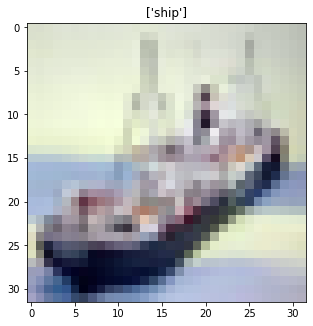

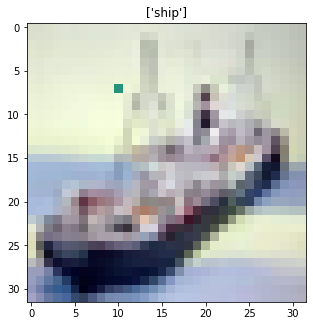

100%|██████████| 1000/1000 [00:27<00:00, 36.11it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 50.900000 %


(56.3, 50.9)

In [ ]:
one_pixel = torchattacks.OnePixel(model, pixels=1, steps=10, popsize=10, inf_batch=128)
apply_torchattacks(model, one_pixel)

  0%|          | 1/1000 [00:00<02:40,  6.23it/s]

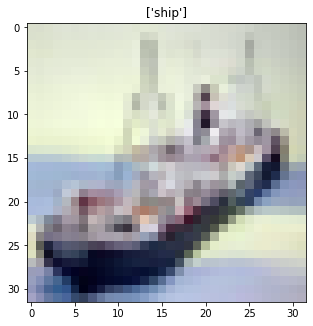

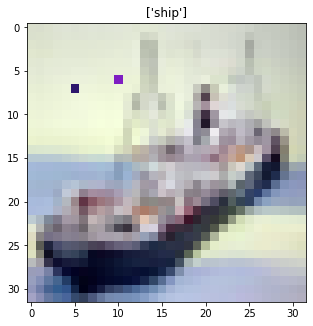

100%|██████████| 1000/1000 [00:34<00:00, 28.83it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 48.600000 %


(56.3, 48.6)

In [ ]:
one_pixel = torchattacks.OnePixel(model, pixels=2, steps=10, popsize=10, inf_batch=128)
apply_torchattacks(model, one_pixel)

  0%|          | 0/1000 [00:00<?, ?it/s]

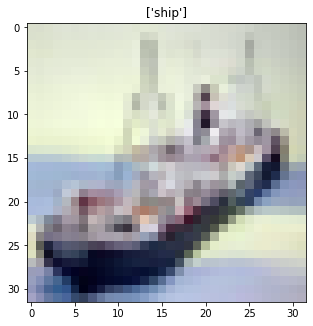

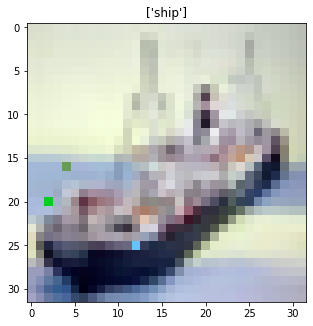

100%|██████████| 1000/1000 [00:38<00:00, 26.00it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 46.700000 %


(56.3, 46.7)

In [ ]:
one_pixel = torchattacks.OnePixel(model, pixels=3, steps=10, popsize=10, inf_batch=128)
apply_torchattacks(model, one_pixel)

  0%|          | 0/1000 [00:00<?, ?it/s]

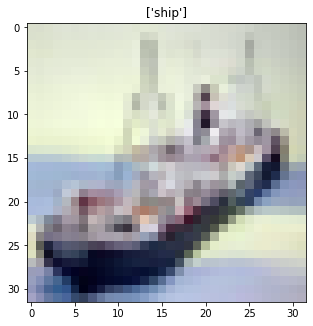

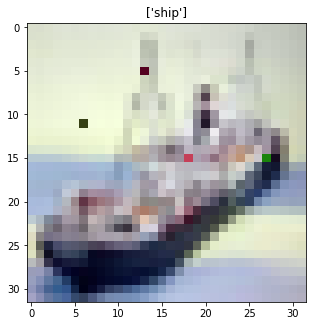

100%|██████████| 1000/1000 [00:53<00:00, 18.62it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 43.000000 %


(56.3, 43.0)

In [ ]:
one_pixel = torchattacks.OnePixel(model, pixels=4, steps=10, popsize=10, inf_batch=128)
apply_torchattacks(model, one_pixel)

### One Pixel Attack to Ensemble

In [ ]:
apply_onepixel_ensemble(pixels=1, steps=10, popsize=10, inf_batch=128, n_models=10)

100%|██████████| 1000/1000 [03:35<00:00,  4.63it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 54.700000 %


(60.8, 54.7)

In [ ]:
apply_onepixel_ensemble(pixels=2, steps=10, popsize=10, inf_batch=128, n_models=10)

100%|██████████| 1000/1000 [04:07<00:00,  4.04it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 52.000000 %


(60.8, 52.0)

In [ ]:
apply_onepixel_ensemble(pixels=3, steps=10, popsize=10, inf_batch=128, n_models=10)

100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 48.900000 %


(60.8, 48.9)

In [ ]:
apply_onepixel_ensemble(pixels=4, steps=10, popsize=10, inf_batch=128, n_models=10)

100%|██████████| 1000/1000 [07:56<00:00,  2.10it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 48.100000 %


(60.8, 48.1)

### Carlini&Wagner Attack to Base Model

In [ ]:
model = Net()
model.load_state_dict(torch.load(f'img_weights/model_base.pt'))
_ = model.eval()

  0%|          | 1/1000 [00:00<01:43,  9.64it/s]

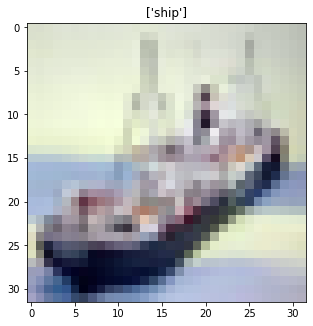

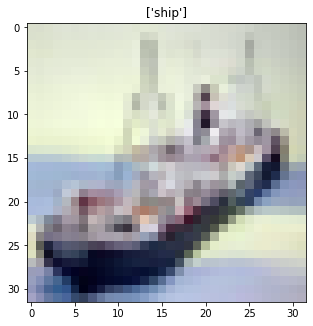

100%|██████████| 1000/1000 [00:09<00:00, 103.67it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 56.100000 %


(56.3, 56.1)

In [ ]:
cw = torchattacks.CW(model, c=0, kappa=0, steps=10, lr=0.01)
apply_cw(model, cw)

  0%|          | 0/1000 [00:00<?, ?it/s]

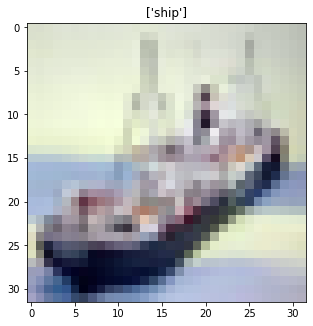

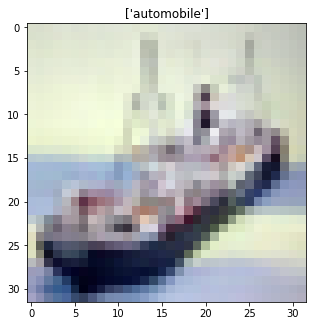

100%|██████████| 1000/1000 [00:11<00:00, 84.69it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 27.000000 %


(56.3, 27.0)

In [ ]:
cw = torchattacks.CW(model, c=0.1, kappa=0, steps=10, lr=0.01)
apply_cw(model, cw)

  0%|          | 1/1000 [00:00<02:51,  5.82it/s]

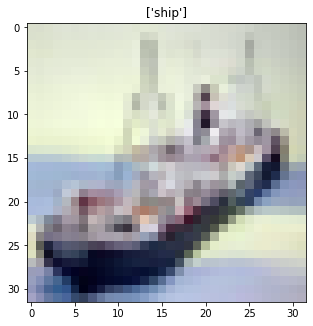

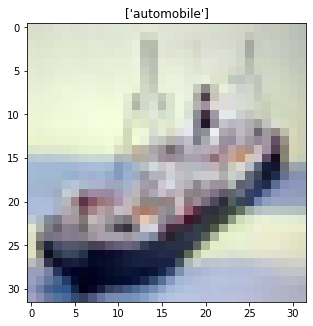

100%|██████████| 1000/1000 [00:12<00:00, 77.88it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 13.600000 %


(56.3, 13.6)

In [ ]:
cw = torchattacks.CW(model, c=0.2, kappa=0, steps=10, lr=0.01)
apply_cw(model, cw)

  0%|          | 1/1000 [00:00<03:06,  5.36it/s]

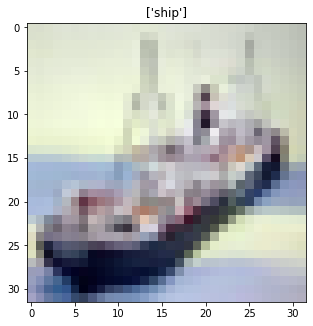

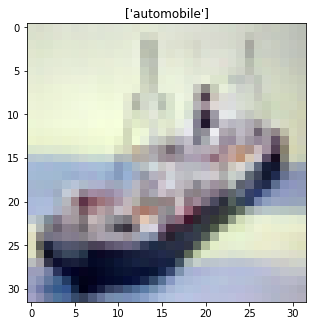

100%|██████████| 1000/1000 [00:12<00:00, 78.61it/s]


Accuracy of test text: 56.300000 %
Accuracy of test text: 4.800000 %


(56.3, 4.8)

In [ ]:
cw = torchattacks.CW(model, c=0.5, kappa=0, steps=10, lr=0.01)
apply_cw(model, cw)

### Carlini&Wagner Attack to Ensemble

In [ ]:
apply_cw_ensemble(c=0, kappa=0, steps=10, lr=0.01, n_models=10)

100%|██████████| 1000/1000 [00:57<00:00, 17.26it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 60.600000 %


(60.8, 60.6)

In [ ]:
apply_cw_ensemble(c=0.1, kappa=0, steps=10, lr=0.01, n_models=10)

100%|██████████| 1000/1000 [01:34<00:00, 10.63it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 25.900000 %


(60.8, 25.9)

In [ ]:
apply_cw_ensemble(c=0.2, kappa=0, steps=10, lr=0.01, n_models=10)

100%|██████████| 1000/1000 [01:36<00:00, 10.33it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 10.600000 %


(60.8, 10.6)

In [ ]:
apply_cw_ensemble(c=0.5, kappa=0, steps=10, lr=0.01, n_models=10)

100%|██████████| 1000/1000 [01:33<00:00, 10.74it/s]


Accuracy of test text: 60.800000 %
Accuracy of test text: 3.600000 %


(60.8, 3.6)